## Official LightAutoML github repository is [here](https://github.com/sberbank-ai-lab/LightAutoML)

## Upvote is the best motivator 👍

# Step 0.0. LightAutoML installation

This step can be used if you are working inside Google Colab/Kaggle kernels or want to install LightAutoML on your machine:

In [1]:
!pip install -U lightautoml

# Step 0.1. Библиотеки

Тут стандарт:
- Стандартные  python библиотеки для  OS и т.п..
- Стандарт обработки DS : numpy, pandas, scikit-learn и torch (для нескольких этапов, не обязателеных)
- LightAutoML модули

In [2]:
# Standard python libraries
import os
import time

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, precision_recall_fscore_support,r2_score
from sklearn.model_selection import train_test_split
import torch

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco

In [21]:
import matplotlib.pyplot as plt


# Step 0.2. Установим константы текущего сеанса

Для этой работы берем:
- `N_THREADS` - число  vCPU для создания LightAutoML 
- `N_FOLDS` - число фолдов для LightAutoML CV
- `RANDOM_STATE` - для повторяемости
- `TEST_SIZE` - размер отложенной выборки 
- `TIMEOUT` - Лимит времени для обучения
- `TARGET_NAME` - имя целевого свойства

In [34]:
N_THREADS = 6
N_FOLDS = 3
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 2 * 360
TARGET_NAME = 'price'

# Step 0.3. Imported models setup

For better reproducibility we fix numpy random seed with max number of threads for Torch (which usually try to use all the threads on server):

In [5]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

# Step 0.4. Data loading
Let's check the data we have:

In [28]:
from google.colab import drive
drive.mount('/gdrive')


Mounted at /gdrive


In [31]:
path ='/gdrive/MyDrive/2_ver_actual Артем Зраев. 10.2020/Lection7/'

In [35]:
%%time

train_data = pd.read_csv(path + "kc_house_data.csv")
train_data.head()

CPU times: user 46.6 ms, sys: 4.05 ms, total: 50.7 ms
Wall time: 57.1 ms


In [36]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

# Step 0.5. Data splitting for train-holdout
As we have only one file with target values, we can split it into 80%-20% for holdout usage:

In [37]:
%%time

tr_data, te_data = train_test_split(train_data, 
                                    test_size=TEST_SIZE, 
                                    #stratify=train_data[TARGET_NAME], 
                                    random_state=RANDOM_STATE)
print('Data splitted. Parts sizes: tr_data = {}, te_data = {}'.format(tr_data.shape, te_data.shape))

Data splitted. Parts sizes: tr_data = (17290, 21), te_data = (4323, 21)
CPU times: user 11.3 ms, sys: 0 ns, total: 11.3 ms
Wall time: 12.1 ms


In [38]:
tr_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
6325,5467910190,20140527T000000,325000.0,3,1.75,1780,13095,1.0,0,0,4,9,1780,0,1983,0,98042,47.3670,-122.152,2750,13095
13473,9331800580,20150310T000000,257000.0,2,1.00,1000,3700,1.0,0,0,3,6,800,200,1929,0,98118,47.5520,-122.290,1270,5000
17614,2407000405,20150226T000000,228500.0,3,1.00,1080,7486,1.5,0,0,3,6,990,90,1942,0,98146,47.4838,-122.335,1170,7800
16970,5466700290,20150108T000000,288000.0,3,2.25,2090,7500,1.0,0,0,4,7,1280,810,1977,0,98031,47.3951,-122.172,1800,7350
20868,3026059361,20150417T000000,479000.0,2,2.50,1741,1439,2.0,0,0,3,8,1446,295,2007,0,98034,47.7043,-122.209,2090,10454


# =============== LightAutoML model building ===============


# Step 1. Task setup

On the cell below we create Task object - the class to setup what task LightAutoML model should solve with specific loss and metric if necessary (more info can be found [here](https://lightautoml.readthedocs.io/en/latest/generated/lightautoml.tasks.base.Task.html#lightautoml.tasks.base.Task) in our documentation):

In [12]:
%%time

task = Task('reg',  metric='mae' )

CPU times: user 2.53 ms, sys: 0 ns, total: 2.53 ms
Wall time: 3.86 ms


# Step 2. Feature roles setup

To solve the task, we need to setup columns roles. The **only role you must setup is target role**, everything else (drop, numeric, categorical, group, weights etc.) is up to user - LightAutoML models have automatic columns typization inside:

In [39]:
%%time

roles = {'target': TARGET_NAME,
         'drop': ['zipcode','id','date']
         }

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 13.6 µs


# Step 3. LightAutoML model creation - TabularAutoML preset

`TabularAutoML` класс для обучения табличных моделей :

<img src="https://github.com/sberbank-ai-lab/lightautoml-datafest-workshop/raw/master/imgs/tutorial_blackbox_pipeline.png" alt="TabularAutoML preset pipeline" style="width:70%;"/>

Параметры:
- `task` - тип ML tзадачи (нужен обязательно **must have** )
- `timeout` - лимит времени на решение
- `cpu_limit` - vCPU число вычислителей на задачу
- `reader_params` - параметры для чтения объектов н=и этапа их процессинга: типизация, предварительные обработки,  CV установки. Например: `n_jobs` потоки для алгоритма , `cv` число фолдов и т.п..
- `general_params` - 'use_algos' указания для алгоритмов в составе модели.

**Important note**: `TabularAutoML` preset. [More details](https://github.com/sberbank-ai-lab/LightAutoML/blob/master/lightautoml/automl/presets/tabular_config.yml) 

`general_params->use_algos`)  [article on TowardsDataScience](https://towardsdatascience.com/lightautoml-preset-usage-tutorial-2cce7da6f936).
 

In [40]:
%%time 

automl = TabularAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                       general_params={'use_algos': [['linear_l2', 'lgb']]}
                      )

RD = ReportDeco(output_path = 'tabularAutoML_model_report')
automl_rd = RD(automl)

oof_pred = automl_rd.fit_predict(tr_data, roles = roles)
print('oof_pred:\n{}\nShape = {}'.format(oof_pred, oof_pred.shape))

Start automl preset with listed constraints:
- time: 720 seconds
- cpus: 6 cores
- memory: 16 gb

Train data shape: (17290, 21)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 709.0545454025269 secs
Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = -142956.118342297
Linear model: C = 5e-05 score = -127239.51749002429
Linear model: C = 0.0001 score = -126970.45699058814
Linear model: C = 0.0005 score = -128770.0100407703
Linear model: C = 0.001 score = -128770.0210248959

===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = -143950.24369902827
Linear model: C = 5e-05 score = -125977.4902611487
Linear model: C = 0.0001 score = -125497.41418315114
Linear model: C = 0.0005 score = -125497.41926405518
Linear model: C = 0.001 score = -127517.39615326219

===== Start working with fold 2 for Lvl_0_

# Step 4. Feature importances calculation 

2 метода в LightAutoML:
- Fast (`fast`) - по моделям.
- Accurate (`accurate`) - более сложный *features permutation importances* .


CPU times: user 53.3 ms, sys: 2.98 ms, total: 56.3 ms
Wall time: 59.6 ms


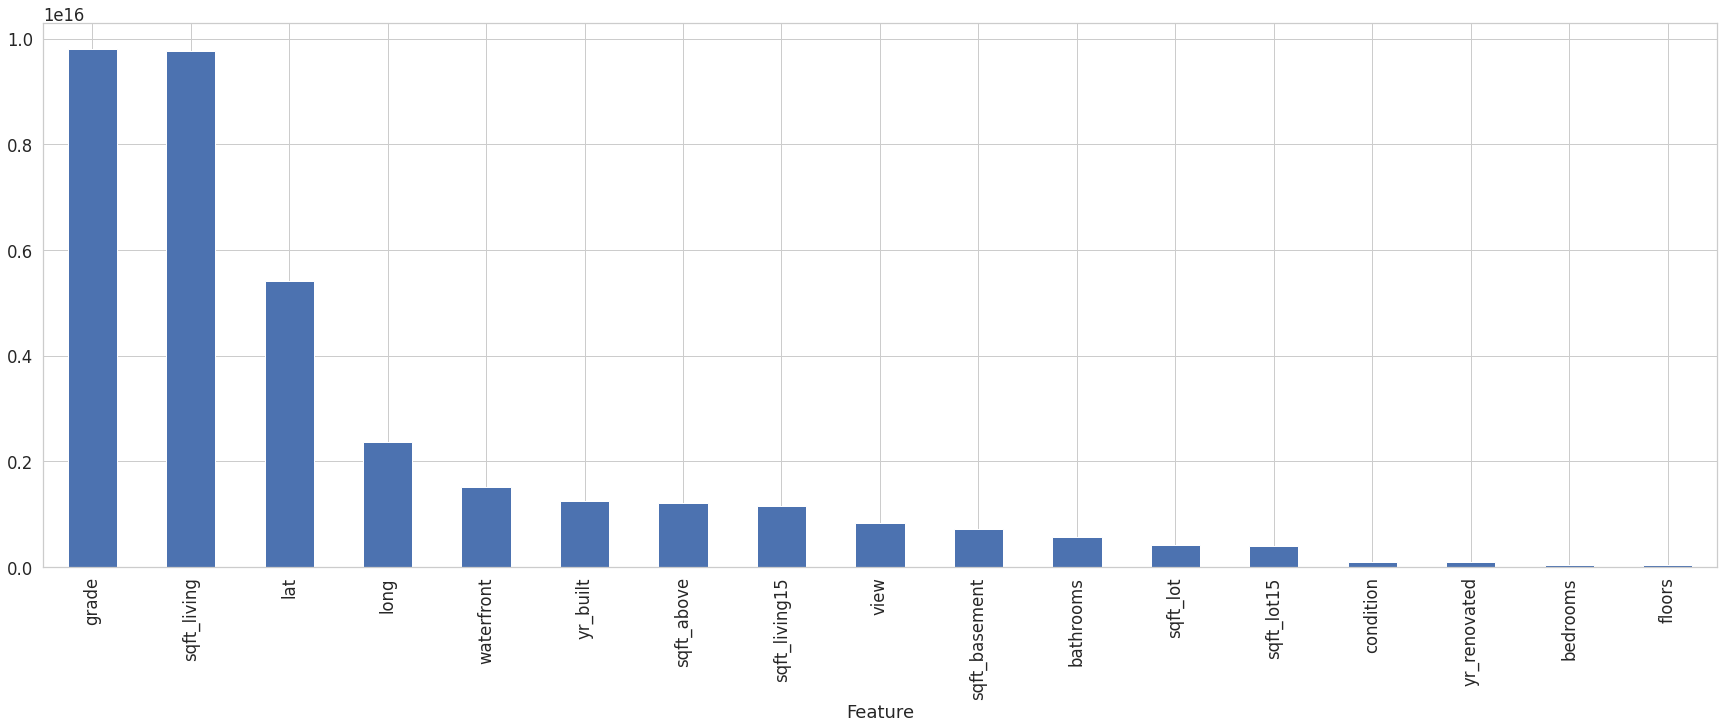

In [41]:
%%time

# Fast feature importances calculation
fast_fi = automl_rd.model.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

In [42]:
# Number of features used by LightAutoML model
len(automl_rd.model.collect_used_feats())

17

In [43]:
%%time

# Accurate feature importances calculation (Permutation importances) -  can take long time to calculate
accurate_fi = automl_rd.model.get_feature_scores(   'accurate', te_data.sample(4000), silent = False)

LightAutoML used 17 feats
1/17 Calculated score for view: 4951.8607148
2/17 Calculated score for grade: 38028.9536211
3/17 Calculated score for sqft_lot: 12343.3084922
4/17 Calculated score for sqft_living: 45256.5146729
5/17 Calculated score for sqft_living15: 6060.1243984
6/17 Calculated score for sqft_basement: 399.8794766
7/17 Calculated score for bedrooms: 494.7655547
8/17 Calculated score for bathrooms: 1020.6532969
9/17 Calculated score for long: 44040.8190000
10/17 Calculated score for lat: 112655.4080801
11/17 Calculated score for waterfront: 4408.9428242
12/17 Calculated score for yr_built: 1527.9151953
13/17 Calculated score for yr_renovated: 1452.8303359
14/17 Calculated score for condition: 3568.9580820
15/17 Calculated score for sqft_above: 4154.5962969
16/17 Calculated score for sqft_lot15: 1231.7019609
17/17 Calculated score for floors: 534.1207891
CPU times: user 1min 11s, sys: 128 ms, total: 1min 11s
Wall time: 37.2 s


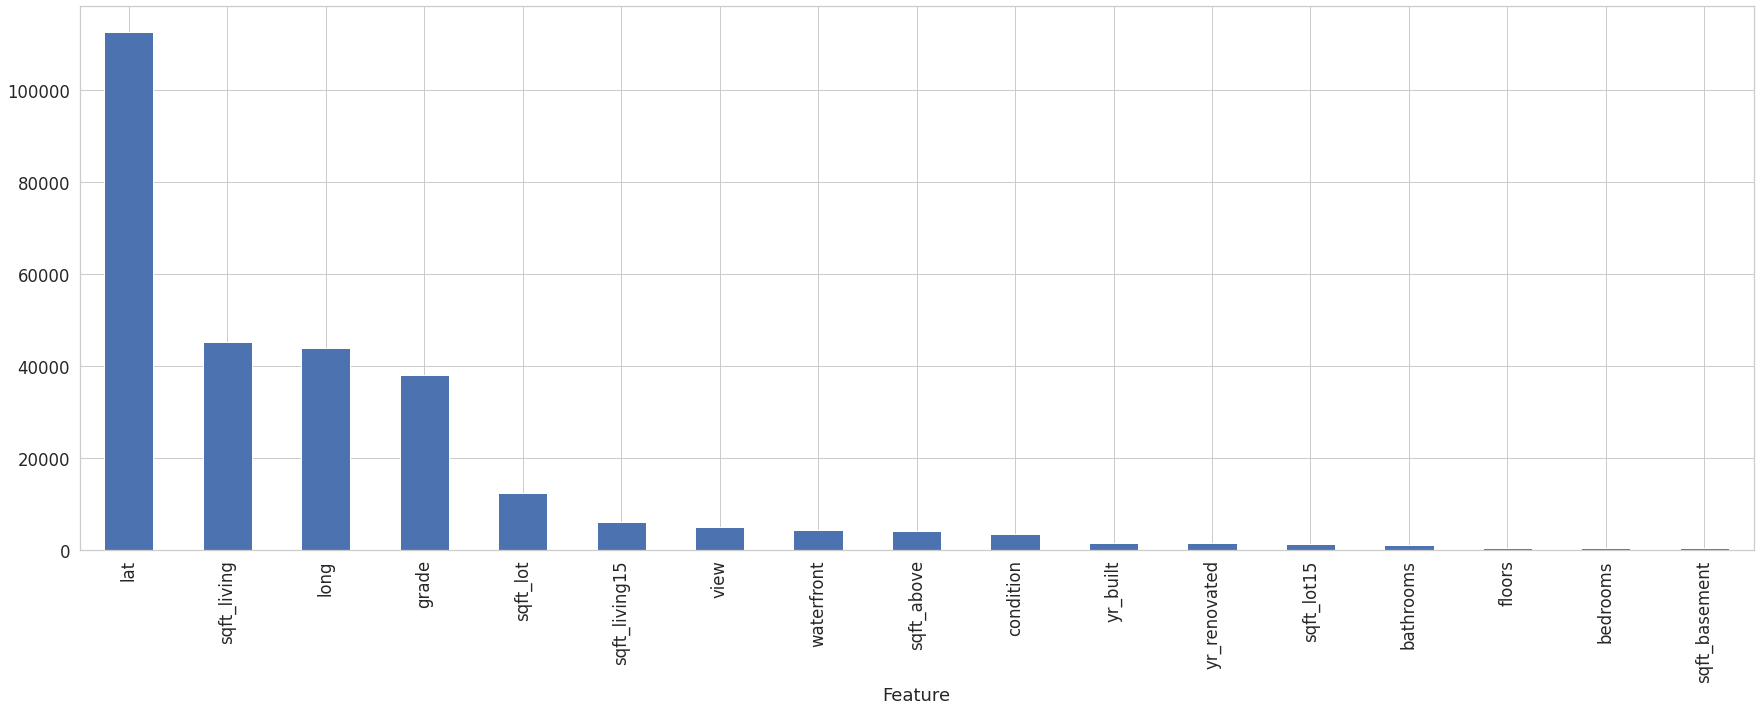

In [45]:
accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

# Step 5. Prediction on holdout and metric calculation

In [46]:
%%time

te_pred = automl_rd.predict(te_data)
print('Prediction for te_data:\n{}\nShape = {}'
              .format(te_pred, te_pred.shape))

Prediction for te_data:
array([[ 376152.47],
       [ 983245.75],
       [1127021.6 ],
       ...,
       [ 303589.12],
       [ 596179.94],
       [ 331096.72]], dtype=float32)
Shape = (4323, 1)
CPU times: user 8.99 s, sys: 254 ms, total: 9.24 s
Wall time: 6.94 s


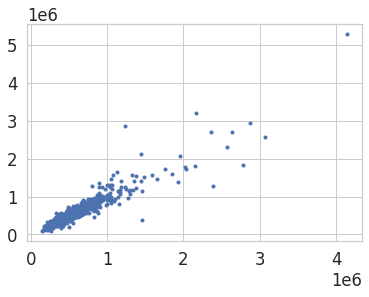

In [47]:
N = 1000

plt.plot(oof_pred.data[:N,0],tr_data[TARGET_NAME].values[:N],'.')
plt.show()

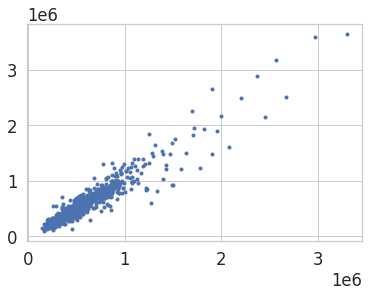

In [60]:
N = 1000

plt.plot(te_pred.data[:N,0],te_data[TARGET_NAME].values[:N],'.')
plt.show()

In [49]:
r2_t = r2_score(tr_data[TARGET_NAME].values[:1000],oof_pred.data[:1000, 0] )
r2_te = r2_score(te_data[TARGET_NAME].values, (te_pred.data[:, 0] ))
print('Check scores...')
print('OOF score: {}'.format(r2_t))
print('HOLDOUT score: {}'.format(r2_te))

Check scores...
OOF score: 0.8791243709105572
HOLDOUT score: 0.874146873308994


# Additional materials

- [Official LightAutoML github repo](https://github.com/sberbank-ai-lab/LightAutoML)
- [LightAutoML documentation](https://lightautoml.readthedocs.io/en/latest)

In [52]:
automl_rd.model.collect_used_feats()

['view',
 'grade',
 'sqft_lot',
 'sqft_living',
 'sqft_living15',
 'sqft_basement',
 'bedrooms',
 'bathrooms',
 'long',
 'lat',
 'waterfront',
 'yr_built',
 'yr_renovated',
 'condition',
 'sqft_above',
 'sqft_lot15',
 'floors']

In [59]:
automl_rd.model.collect_model_stats()

{'Lvl_0_Pipe_1_Mod_0_LightGBM': 3}